# Models

In [1]:
# Change here
# This notebook needs to be downloaded and run on a local computer
file_name = "merged_df.csv"  # the csv should in the same folder as this notebook
predict_column_name = 'target'
x_drop_columns = ['target', 'Unnamed: 0', 'day', 'hadm_id']

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE



In [3]:
merged_table = pd.read_csv(file_name)

X = merged_table.drop(columns=x_drop_columns)
y = merged_table[predict_column_name]

mapping_dict = {True: 1, False: 0}
y = y.map(mapping_dict)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train = X_train_smote
y_train = y_train_smote


In [4]:
X

,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,spo2,warning_skin,warning_gastro,eosinophils_abs,eosinophils
0,84.937500,98.800000,69.775000,79.175000,95.428571,75.428571,83.000000,15.305556,100.000000,0,0,0.06,1.2
1,95.961538,111.032258,75.919355,86.951613,108.733333,83.333333,92.266667,20.206897,99.034483,0,0,0.00,0.0
2,77.958333,112.480000,80.760000,91.560000,110.187500,84.937500,94.187500,19.083333,97.500000,0,0,0.00,0.0
3,77.666667,117.222222,85.666667,96.000000,117.222222,85.666667,96.000000,23.888889,95.666667,0,0,0.00,0.0
4,80.000000,104.000000,59.000000,73.000000,113.000000,59.000000,68.000000,18.000000,100.000000,0,0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82250,64.384615,132.446429,52.232143,73.672414,127.350000,50.700000,69.650000,15.961538,99.076923,0,0,0.00,0.0
82251,58.720000,129.791667,53.791667,72.041667,129.791667,53.791667,72.041667,16.160000,96.400000,0,0,0.00,0.0
82252,69.333333,125.941176,48.235294,66.882353,125.941176,48.235294,66.882353,17.277778,95.555556,0,0,0.00,0.0
82253,80.000000,104.000000,59.000000,73.000000,113.000000,59.000000,68.000000,18.000000,100.000000,0,0,0.00,0.0


### Logistic Regression


In [5]:
log_reg_ori = LogisticRegression(max_iter=1000, random_state=42)
log_reg_ori.fit(X_train, y_train)
y_pred_lr_ori = log_reg_ori.predict(X_test)

In [6]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


# Define the parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Perform grid search
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Get the best parameters and accuracy
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation accuracy for Logistic Regression:", grid_search_lr.best_score_)


Best parameters for Logistic Regression: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 0.6352215220480014


In [7]:
log_reg = LogisticRegression(C=100, max_iter=100, solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

### Naive Bayes

In [8]:
nb_model_ori = GaussianNB()
nb_model_ori.fit(X_train, y_train)
y_pred_nb_ori = nb_model_ori.predict(X_test)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

# Set up GridSearchCV with GaussianNB
grid_search_nb = GridSearchCV(GaussianNB(), param_grid, cv=10, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)

# Get the best parameters and best score
print(f"Best parameters for GaussianNB: {grid_search_nb.best_params_}")
print(f"Best cross-validation accuracy for GaussianNB: {grid_search_nb.best_score_}")

Best parameters for GaussianNB: {'var_smoothing': 0.001}
Best cross-validation accuracy for GaussianNB: 0.575263950209122


In [10]:
nb_model = GaussianNB(var_smoothing=0.001)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

### Random Forest

In [11]:
rf_model_ori = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_ori.fit(X_train, y_train)
y_pred_rf_ori = rf_model_ori.predict(X_test)

In [12]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
   'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]   
}

# Initialize the GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                              param_grid=param_grid_rf, 
                              cv=2, 
                              scoring='accuracy', 
                              n_jobs=-1, 
                              verbose=0)

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Display the best parameters and best cross-validation accuracy
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy for Random Forest: 0.7564583301317023


In [13]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

### XGBoost

In [14]:
xgb_ori = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_ori.fit(X_train, y_train)
y_pred_xgb_ori = xgb_ori.predict(X_test)

In [15]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
warnings.filterwarnings("ignore", category=UserWarning)

# Define the parameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100, 150],        
    'max_depth': [3, 5, 7],                 
    'learning_rate': [0.01, 0.1, 0.2],       
    'subsample': [0.8, 1.0],             
    'colsample_bytree': [0.8, 1.0]       
}

# Initialize the XGBClassifier model
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, verbosity=0, random_state=42)

# Set up GridSearchCV for parameter tuning with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)  # Fit model to training data with cross-validation

# Print the best parameters and the best cross-validation accuracy score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Best cross-validation accuracy for XGBoost: 0.7520247344666213


In [16]:
xgb = XGBClassifier(
    eval_metric='logloss', 
    use_label_encoder=False, 
    colsample_bytree=1.0, 
    learning_rate=0.2, 
    max_depth=7, 
    n_estimators=150, 
    subsample=0.8, 
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Results

### Accuracy

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Calculate accuracy scores
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

accuracy_lr_ori = accuracy_score(y_test, y_pred_lr_ori)
accuracy_nb_ori = accuracy_score(y_test, y_pred_nb_ori)
accuracy_rf_ori = accuracy_score(y_test, y_pred_rf_ori)
accuracy_xgb_ori = accuracy_score(y_test, y_pred_xgb_ori)

# Create a DataFrame to store the results
accuracy_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'XGBoost'],
    'Original Accuracy (%)': [accuracy_lr_ori * 100, accuracy_nb_ori * 100, accuracy_rf_ori * 100, accuracy_xgb_ori * 100],
    'Tuned Accuracy (%)': [accuracy_lr * 100, accuracy_nb * 100, accuracy_rf * 100, accuracy_xgb * 100]
})

# Display the DataFrame
display(accuracy_df)


,Model,Original Accuracy (%),Tuned Accuracy (%)
0,Logistic Regression,35.949182,36.423318
1,Naive Bayes,11.525135,19.117379
2,Random Forest,53.145705,53.145705
3,XGBoost,50.325208,51.151906


### Confusion Matrix

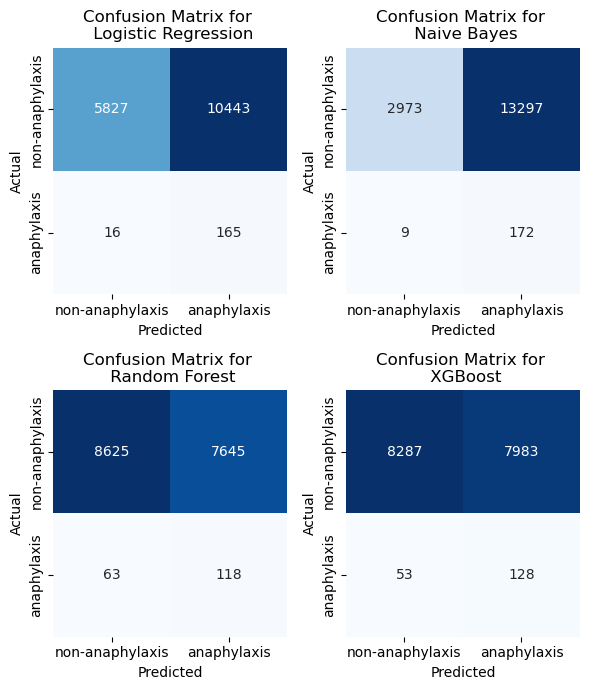

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

models = {
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

plt.figure(figsize=(6, 7))

for i, (name, y_pred) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(2, 2, i)  # Arrange in a 2x2 grid
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=["non-anaphylaxis", "anaphylaxis"], 
                yticklabels=["non-anaphylaxis", "anaphylaxis"])

    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for \n {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


### Classification Report

In [29]:
from sklearn.metrics import classification_report
import pandas as pd

predictions = {
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

report_dfs = {}

for name, y_pred in predictions.items():
    report = classification_report(y_test, y_pred, target_names=["non-anaphylaxis", "anaphylaxis"], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_dfs[name] = report_df

for name, report_df in report_dfs.items():
    print(f"{name} Classification Report:")
    display(report_df)
    print("\n" + "="*50 + "\n")


Logistic Regression Classification Report:


,precision,recall,f1-score,support
non-anaphylaxis,0.997262,0.358144,0.527020,16270.000000
anaphylaxis,0.015554,0.911602,0.030587,181.000000
accuracy,0.364233,0.364233,0.364233,0.364233
macro avg,0.506408,0.634873,0.278804,16451.000000
weighted avg,0.986461,0.364233,0.521558,16451.000000




Naive Bayes Classification Report:


,precision,recall,f1-score,support
non-anaphylaxis,0.996982,0.182729,0.308851,16270.000000
anaphylaxis,0.012770,0.950276,0.025201,181.000000
accuracy,0.191174,0.191174,0.191174,0.191174
macro avg,0.504876,0.566503,0.167026,16451.000000
weighted avg,0.986153,0.191174,0.305730,16451.000000




Random Forest Classification Report:


,precision,recall,f1-score,support
non-anaphylaxis,0.992749,0.530117,0.691161,16270.000000
anaphylaxis,0.015200,0.651934,0.029708,181.000000
accuracy,0.531457,0.531457,0.531457,0.531457
macro avg,0.503974,0.591025,0.360435,16451.000000
weighted avg,0.981993,0.531457,0.683884,16451.000000




XGBoost Classification Report:


,precision,recall,f1-score,support
non-anaphylaxis,0.993645,0.509342,0.673466,16270.000000
anaphylaxis,0.015781,0.707182,0.030873,181.000000
accuracy,0.511519,0.511519,0.511519,0.511519
macro avg,0.504713,0.608262,0.352170,16451.000000
weighted avg,0.982886,0.511519,0.666396,16451.000000


In [33]:
# Create a summary table with key metrics for both classes
summary_data = {
    "Model": [],
    "Accuracy": [],
    "Precision \n(non-anaphylaxis)": [],
    "Recall \n(non-anaphylaxis)": [],
    "F1-Score \n(non-anaphylaxis)": [],
    "Precision \n(anaphylaxis)": [],
    "Recall \n(anaphylaxis)": [],
    "F1-Score \n(anaphylaxis)": []
}

for name, y_pred in predictions.items():
    report = classification_report(y_test, y_pred, target_names=["non-anaphylaxis", "anaphylaxis"], output_dict=True)
    summary_data["Model"].append(name)
    summary_data["Accuracy"].append(report["accuracy"])
    summary_data["Precision \n(non-anaphylaxis)"].append(report["non-anaphylaxis"]["precision"])
    summary_data["Recall \n(non-anaphylaxis)"].append(report["non-anaphylaxis"]["recall"])
    summary_data["F1-Score \n(non-anaphylaxis)"].append(report["non-anaphylaxis"]["f1-score"])
    summary_data["Precision \n(anaphylaxis)"].append(report["anaphylaxis"]["precision"])
    summary_data["Recall \n(anaphylaxis)"].append(report["anaphylaxis"]["recall"])
    summary_data["F1-Score \n(anaphylaxis)"].append(report["anaphylaxis"]["f1-score"])

# Convert to DataFrame for better display
summary_df = pd.DataFrame(summary_data)
display(summary_df)


,Model,Accuracy,Precision \n(non-anaphylaxis),Recall \n(non-anaphylaxis),F1-Score \n(non-anaphylaxis),Precision \n(anaphylaxis),Recall \n(anaphylaxis),F1-Score \n(anaphylaxis)
0,Logistic Regression,0.364233,0.997262,0.358144,0.527020,0.015554,0.911602,0.030587
1,Naive Bayes,0.191174,0.996982,0.182729,0.308851,0.012770,0.950276,0.025201
2,Random Forest,0.531457,0.992749,0.530117,0.691161,0.015200,0.651934,0.029708
3,XGBoost,0.511519,0.993645,0.509342,0.673466,0.015781,0.707182,0.030873


### Feature Importance

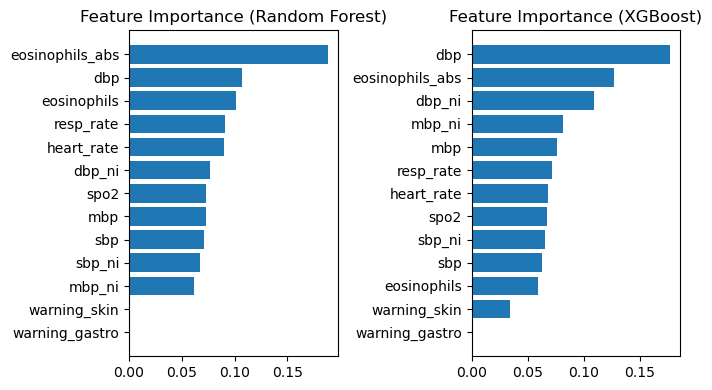

In [21]:
importances_dict = {
    "Random Forest": rf_model.feature_importances_,
    "XGBoost": xgb.feature_importances_
}

plt.figure(figsize=(7, 4))
for i, (name, importances) in enumerate(importances_dict.items(), 1):
    indices = np.argsort(importances)[::-1]
    plt.subplot(1, len(importances_dict), i)
    plt.title(f"Feature Importance ({name})")
    plt.barh(range(X.shape[1]), importances[indices], align="center")
    plt.yticks(range(X.shape[1]), X.columns[indices])
    plt.gca().invert_yaxis()
    plt.tight_layout()

plt.show()


### Precision-Recall Curves

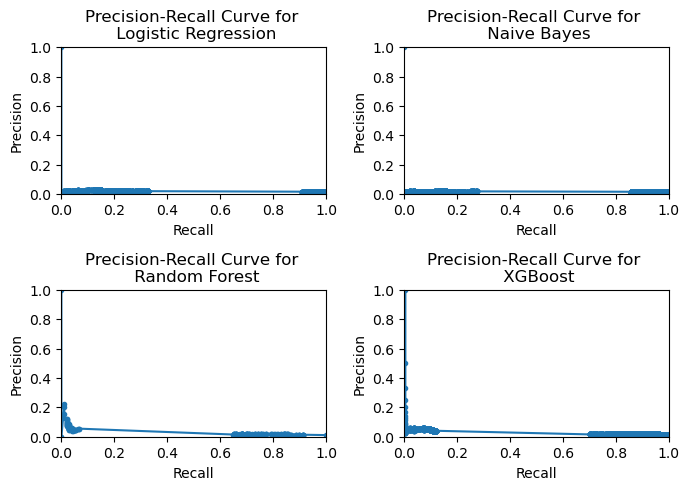

In [22]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curves for All Models
plt.figure(figsize=(7, 7))
for i, (name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(3, 2, i)
    if name == "Logistic Regression":
        y_prob = log_reg.predict_proba(X_test)[:, 1]
    elif name == "Naive Bayes":
        y_prob = nb_model.predict_proba(X_test)[:, 1]
    elif name == "Random Forest":
        y_prob = rf_model.predict_proba(X_test)[:, 1]
    elif name == "XGBoost":
        y_prob = xgb.predict_proba(X_test)[:, 1]


    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for \n {name}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

plt.tight_layout()
plt.show()


### Learning Curves

/Users/lydialyu/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lydialyu/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lydialyu/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lydialyu/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

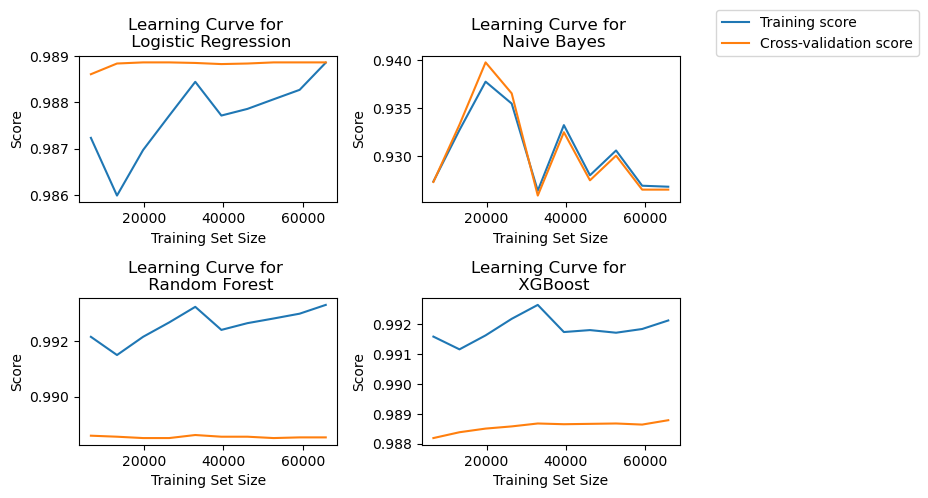

In [23]:
from sklearn.model_selection import learning_curve

plt.figure(figsize=(7, 5))
for i, (name, model) in enumerate([("Logistic Regression", log_reg),
                                   ("Naive Bayes", nb_model),
                                   ("Random Forest", rf_model),
                                   ("XGBoost", xgb)], 1):
    plt.subplot(2, 2, i)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_mean)
    plt.plot(train_sizes, test_mean)
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.title(f"Learning Curve for \n {name}")

# Add a single legend outside the last subplot
plt.figlegend(["Training score", "Cross-validation score"], loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1)
plt.tight_layout()
plt.show()
